In [11]:
# Imports of Pandas and related packages
import pandas as pd
import numpy as np
%matplotlib inline

In [12]:
# Imports of plotting and data visualization libraries --Maybe? Idk this could be totally useless. Pictures are fun right?
import hvplot.pandas
import matplotlib.pyplot as plt

In [13]:
# Importing pickle files to plug in later. Time to have fun

bitcoin_df = pd.read_pickle('bitcoin_df.pkl')
bitcoin_sma_strategy = pd.read_pickle('btc_sma.pkl')
bitcoin_macd_strategy = pd.read_pickle('btc_macd.pkl')

ethereum_df = pd.read_pickle('ethereum_df.pkl')
ethereum_sma_strategy = pd.read_pickle('eth_sma.pkl')
ethereum_macd_strategy = pd.read_pickle('eth_macd.pkl')

solana_df = pd.read_pickle('solana_df.pkl')
solana_sma_strategy = pd.read_pickle('sol_sma.pkl')
solana_macd_strategy = pd.read_pickle('sol_macd.pkl')

<AxesSubplot:>

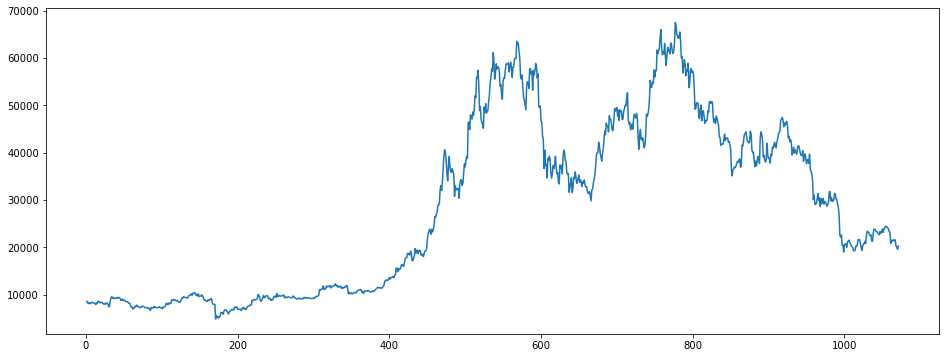

In [14]:
bitcoin_df['close'].plot(figsize=(16,6))

In [15]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [16]:
btc_future = bitcoin_df.loc[450:1070]

In [17]:
btc_future.drop(["open_time", "close_time"], axis=1, inplace=True)
btc_future = btc_future.reset_index(drop=True)
btc_future.head()

c:\Users\mahlesah\anaconda3.2\envs\dev\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,volume_adi,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,price_action,returns,close_shift
0,19434.32,21537.30,19284.48,21350.80,691.829970,1.410138e+07,12014.0,336.620364,6.852883e+06,8705.919877,...,13.754065,5.201667,8.552398,18821.577896,9.892700,9.433425,150.605951,20401.7250,0.098927,19428.77
1,21341.20,23801.60,21235.72,22812.74,913.689501,2.069573e+07,18731.0,455.105037,1.030059e+07,8915.358984,...,24.866786,9.134691,15.732095,19481.651424,6.847238,6.622994,167.765536,22297.8150,0.068472,21350.80
2,22814.55,23284.91,22351.06,23107.85,307.900695,7.042925e+06,13113.0,120.207863,2.749545e+06,9106.502391,...,20.505827,11.408918,9.096909,20616.147501,1.293619,1.285323,171.229402,22889.5925,0.012936,22812.74
3,23114.04,24172.13,22761.33,23827.87,337.209001,7.941750e+06,12272.0,164.934693,3.889792e+06,9279.141544,...,17.422074,12.611549,4.810525,21651.669470,3.115911,3.068352,179.680668,23468.8425,0.031159,23107.85
4,23817.99,24292.51,23081.64,23476.66,341.499371,8.051306e+06,16541.0,159.855231,3.771440e+06,9160.455656,...,14.897586,13.068757,1.828829,22221.754691,-1.473946,-1.484917,175.558326,23667.2000,-0.014739,23827.87


In [18]:
bdl = btc_future.values
bdl = bdl.astype('float32')
bdl = np.reshape(bdl, (-1,1))

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range = (0, 1))
bdl = scaler.fit_transform(bdl)

# 75/25 split
train_size = int(len(bdl) * 0.75)
test_size = int(len(bdl) - train_size)
train, test = bdl[0:train_size,:], bdl[train_size:len(bdl),:]

In [20]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Window size of 30 to approximate one month of daily trading
window_size = 30
X_train, y_train = create_features(train, window_size)

X_test, y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
### we may not need this, consider deleting this


# Checking to make sure that none of our training set is leaking into the testing set
bdl_shape = bdl.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(bdl_shape, train_shape, test_shape))

False


In [22]:
# Import LSTM for the model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

# Setting seed
tf.random.set_seed(11)
np.random.seed(11)

In [23]:
# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [25]:
filepath = bdl

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, y_train, epochs = 100, batch_size = 20, validation_data = (X_test, y_test), 
                    #callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

Epoch 1/100
2281/2281 [==============================] - 13s 6ms/step - loss: 3.6466e-04 - val_loss: 4.0553e-05
Epoch 2/100
2281/2281 [==============================] - 13s 6ms/step - loss: 1.1076e-04 - val_loss: 4.1632e-05
Epoch 3/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1052e-04 - val_loss: 4.1011e-05
Epoch 4/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1070e-04 - val_loss: 4.0862e-05
Epoch 5/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1068e-04 - val_loss: 4.0932e-05
Epoch 6/100
2281/2281 [==============================] - 17s 8ms/step - loss: 1.1071e-04 - val_loss: 4.0840e-05
Epoch 7/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1070e-04 - val_loss: 4.0842e-05
Epoch 8/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1070e-04 - val_loss: 4.0842e-05
Epoch 9/100
2281/2281 [==============================] - 16s 7ms/step - loss: 1.1070e-04 - val_loss: 4.0

In [27]:
# Evaluate the model
model.evaluate(X_test, y_test)

475/475 [==============================] - 2s 3ms/step - loss: 4.0842e-05


4.0841958252713084e-05

In [28]:
# Make some predictions
predicted = model.predict(X_test)

475/475 [==============================] - 2s 3ms/step


In [29]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [35]:
# Create a DataFrame of Real and Predicted values
btc_prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = bitcoin_df.index[-len(real_prices): ]) # error trying to pass a df into this part.
btc_prices.head()

ValueError: Shape of passed values is (15184, 2), indices imply (1071, 2)

In [ ]:
# Plot the real vs predicted prices as a line chart
btc_prices.plot()